## Save

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys

import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchvision.transforms import Compose, ToTensor, Resize
from torch.utils.data import Subset

from tqdm import tqdm
from torchsummary import summary
import cv2
# from segment_anything import SamPredictor, sam_model_registry
# from segment_anything.utils.transforms import ResizeLongestSide
import nibabel as nib
import torch.nn.functional as F
from skimage import transform, io, segmentation

# set seeds
torch.manual_seed(2023)
np.random.seed(2023)


# create_folders
base = "/content/"
os.makedirs(base + "BraTS_data", exist_ok=True)


# prepare SAM model
# model_type = 'vit_h'
# checkpoint = 'sam_vit_h_4b8939.pth'
# sam_model = sam_model_registry[model_type](checkpoint=checkpoint).to('cuda')

## DATA

In [ ]:
!gcloud auth login

In [ ]:
!sudo zypper install gcc python3-devel
!sudo pip uninstall crcmod
!sudo pip install --no-cache-dir -U crcmod

In [ ]:
!mkdir BraTS_data_africa

In [ ]:
!gcloud config set project 	crafty-nova-394910
!gsutil -m cp -r gs://embedding_spark/BraTS_data_africa/t1/t1 ./BraTS_data_africa/
!gsutil -m cp -r gs://embedding_spark/BraTS_data_africa/t2 ./BraTS_data_africa/
!gsutil -m cp -r gs://embedding_spark/BraTS_data_africa/flair ./BraTS_data_africa/

# Prepare

In [2]:
! pip install monai
! pip install pytorch-lightning
! pip install torchio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 722.8/722.8 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.6/731.6 kB 63.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.8/172.8 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 18.3 MB/s eta 0:00:00


In [3]:
from monai.networks.nets import UNet, AttentionUnet
from torchsummary import summary
import numpy as np
import torch
import os
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchvision.transforms import Compose, ToTensor, Resize
from torch.utils.data import Subset
from tqdm import tqdm
import monai
# from segment_anything import SamPredictor, sam_model_registry
# from segment_anything.utils.transforms import ResizeLongestSide
# import wandb
import nibabel as nib
# from segment_anything.utils.transforms import ResizeLongestSide
import torch.nn.functional as F
from skimage import transform, io, segmentation
import random
import pytorch_lightning as pl
import torchio as tio
from pytorch_lightning.callbacks import ModelCheckpoint



In [11]:
input_path = "/content/drive/MyDrive/voting_data"

class BraTSDataset(Dataset):

    def __init__(self, ground_truth_path, device="cuda", isVal = True):
        """
        Args:
            embedding_path (string): Path to  images.
            masks_path (string): path to masks.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.ground_truth_path = ground_truth_path
        self.device = device

        if isVal:
            self.data = os.listdir(self.ground_truth_path+"/input")[:40]
        else:
            self.data = os.listdir(self.ground_truth_path+"/input")[40:]


    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

      case_name = self.data[idx]

      # input_ = self.data[idx]
      # mask = self.ground_truth_path+"/mask"

      input_ = np.load(self.ground_truth_path+"/input/"+case_name)
      mask   = np.load(self.ground_truth_path+"/mask/"+case_name)

      sample = {"input": input_,
                  'mask': mask,
                  }

      return sample

In [12]:
ground_truth_path = "/content/voting_data"

# !cp -r /content/drive/MyDrive/voting_data /content

In [13]:
train = BraTSDataset(ground_truth_path)

for i in range(len(train)):
  inp = train[i]["input"]
  out = train[i]["mask"]
  # print(train[i])
  break

In [14]:
train = BraTSDataset(ground_truth_path)
val = BraTSDataset(ground_truth_path, isVal = False)

device = "cuda"

print(len(train))
print(len(val))

# train_loader = DataLoader(train, batch_size= 8, shuffle=True, num_workers=2, prefetch_factor= 1)
# val_loader = DataLoader(val, batch_size= 8, shuffle=False, num_workers=2, prefetch_factor= 1)

train_loader = DataLoader(train, batch_size= 4, shuffle=True, num_workers=1, prefetch_factor= 3)
val_loader = DataLoader(val, batch_size= 4, shuffle=False, num_workers=1, prefetch_factor= 3)


hprams = {
    "num_epochs": 200,
    "best_loss": 1e10,
    "model_save_path": "/content/drive/MyDrive/miccai_data",
    "lr":1e-2,
    "weight_decay":0,
    "device": device,
    "train_dataloader": train_loader,
    "val_dataloader": val_loader
    }

40
3


In [9]:
net = AttentionUnet(
    spatial_dims=3,
    in_channels=7,
    out_channels=3,
    channels=(16, 32, 64),
    strides=(2, 2),
).to(device)

In [5]:
!pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 1.2 MB/s eta 0:00:00


In [12]:
from monai.networks.nets import UNETR
from einops.layers.torch import Rearrange
device = "cuda"
# cant fit T4
net = UNETR(in_channels=7,
            out_channels=3,
            img_size=(240,240,155),
            pos_embed='conv',
            norm_name='instance',
            # feature_size=8,
            hidden_size=15,
            num_heads=15
            ).to(device)

net(torch.zeros((7, 240, 240, 155)).to(device))

RuntimeError: ignored

In [1]:
# memory
from monai.networks.nets import SwinUNETR
# cant fit a100
device = "cuda"
net = SwinUNETR(
    in_channels=7,
    out_channels=3,
    img_size=(256,256,160),
    spatial_dims=3,
    # feature_size=12,
    # depths=(2, 2 ),
    # num_heads=(3, 6)
    ).to(device)

In [8]:
from monai.networks.nets import DynUNet

# cant fit a100
net = DynUNet(
    spatial_dims=3,
    in_channels=7,
    out_channels=3,
    kernel_size=(5,5,5),
    strides=(2,2,2),
    upsample_kernel_size=(5,5,5),
).to(device)

In [1]:
from monai.networks.nets import BasicUNetPlusPlus
device = "cuda"
# cant fit a100
net = BasicUNetPlusPlus(
    spatial_dims=3,
    in_channels=7,
    out_channels=3,
    features=(32, 32, 32, 32, 32, 64)
).to(device)

BasicUNetPlusPlus features: (32, 32, 32, 32, 32, 64).


In [11]:
torch.cuda.empty_cache()

In [6]:
summary(net, (7, 240, 240, 155))

AttributeError: ignored

In [ ]:
s = np.zeros((1,7, 240, 240, 155), dtype= np.float32)
s = torch.from_numpy(s).to("cuda")
net(s).shape

IndexError: ignored

In [20]:
loss_function = monai.losses.GeneralizedDiceFocalLoss(sigmoid=False, softmax=True, to_onehot_y = False).to(device)
optimizer = torch.optim.Adam(net.parameters(), hprams["lr"])

def configure_optimizers():
    optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=4)
    return [optimizer], [scheduler]

In [18]:
class Model(pl.LightningModule):
    def __init__(self, net, criterion, learning_rate, optimizer_class):
        super().__init__()
        self.lr = learning_rate
        self.net = net
        self.criterion = criterion
        self.optimizer_class = optimizer_class

    def forward(self, input_):
      return self.net(input_)

    def configure_optimizers(self):
        optimizer = self.optimizer_class(self.parameters(), lr=self.lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=4, verbose=True)
        # return [optimizer], [scheduler]
        return {"optimizer": optimizer,
                "lr_scheduler": scheduler,
                "monitor": "val_loss"}

    def prepare_batch(self, batch):
        return (batch["input"], batch["mask"])



    def infer_batch(self, batch):
        x, y = self.prepare_batch(batch)
        y_hat = self.net(x)
        return y_hat, y

    def training_step(self, batch, batch_idx):
        y_hat, y = self.infer_batch(batch)
        loss = self.criterion(y_hat, y)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        y_hat, y = self.infer_batch(batch)
        loss = self.criterion(y_hat, y)
        self.log("val_loss", loss)
        return loss

In [21]:
model = Model(
    net=net,
    criterion=loss_function,
    learning_rate=hprams["lr"],
    optimizer_class=torch.optim.Adam,
)
early_stopping = pl.callbacks.early_stopping.EarlyStopping(
    monitor="val_loss", patience=10)


checkpoint_callback = ModelCheckpoint(
    dirpath = hprams["model_save_path"],
    filename = "voting_unet_small",
    save_last = True,
    save_top_k=1,
    verbose=True,
    monitor='val_loss',
    mode='min',
)

trainer = pl.Trainer(
    default_root_dir= hprams["model_save_path"],
    callbacks=[early_stopping, checkpoint_callback],
    log_every_n_steps=3,
    max_epochs = hprams["num_epochs"],
    # accelerator="gpu", devices=2, num_nodes=2, strategy="ddp"
)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [22]:
trainer.fit(model, train_loader, val_loader)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:615: UserWarning: Checkpoint directory /content/drive/MyDrive/miccai_data exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type                     | Params
-------------------------------------------------------
0 | net       | UNETR                    | 113 M 
1 | criterion | GeneralizedDiceFocalLoss | 0     
-------------------------------------------------------
113 M     Trainable params
0         Non-trainable params
113 M     Total params
452.201   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

AttributeError: ignored

In [ ]:
# model2 = torch.load(hprams["model_save_path"]+"/voting_unet_small-v4.ckpt")

PATH = hprams["model_save_path"]+"/voting_unet_small-v5.ckpt"
model2 = Model.load_from_checkpoint(PATH,
                                   net=net,
                                   criterion=loss_function,
                                   learning_rate=hprams["lr"],
                                   optimizer_class=torch.optim.Adam
                                   )


[0. 1.]
[0. 1. 2. 3.]


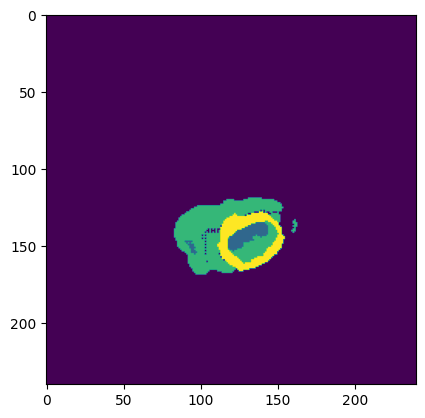

In [ ]:
s = np.load("/content/voting_data/input/BraTS-SSA-00122-000.npy")
s = np.expand_dims(s, axis = 0)
s = torch.as_tensor(s, dtype=torch.float ).to(device)

model2 = model2.to("cuda")

with torch.no_grad():
  out = model2.net(s)


m = out

m =torch.sigmoid(m).cpu().numpy()

# lower_bound, upper_bound = np.percentile(m, 0.5), np.percentile(m, 99.5)
# image_data_pre = np.clip(m, lower_bound, upper_bound)
# d = (np.max(image_data_pre)-np.min(image_data_pre))
# d = 1 if d==0 else d
# image_data_pre = ((image_data_pre - np.min(image_data_pre))/d)
# image_data_pre[m==0] = 0
# m = image_data_pre
thr=0.5
m[m>=thr]= 1
m[m<thr] = 0
# m = 1-m
m = np.squeeze(m, axis = 0)
# m = np.int32(m)
print(np.unique(m))
m = m[:,:,:,:155]

output = np.zeros(m.shape[1:])

msk1 = m[0]
# msk1[msk1>0.5]= 1
msk2 = m[1]
# msk2[msk2>0.5]= 1
msk3 = m[2]
# msk3[msk3>0.5]= 1

output[msk2>0] = 2
output[msk1>0] = 1
output[msk3>0] = 3


print(np.unique(output))


plt.imshow(output[:,:,115])

[0. 1. 2. 3.]


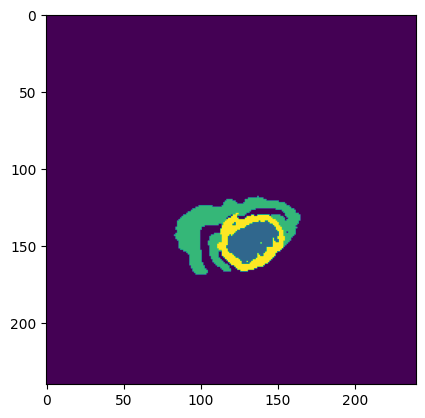

In [ ]:
true = np.load("/content/voting_data/mask/BraTS-SSA-00122-000.npy")

output = np.zeros(true.shape[1:])

msk1 = true[0]
# msk1[msk1>0.5]= 1
msk2 = true[1]
# msk2[msk2>0.5]= 1
msk3 = true[2]
# msk3[msk3>0.5]= 1

output[msk1>0] = 1
output[msk2>0] = 2
output[msk3>0] = 3
print(np.unique(output))


plt.imshow(output[:,:,115])

In [ ]:
s = np.zeros((1,7, 240, 240, 155), dtype= np.float32)
s = torch.from_numpy(s).to("cuda")
model2 = model2.to("cuda")
print(model2.net(s).shape)

model2.freeze()

with torch.no_grad():
    y_hat = model2(s)

print(y_hat.shape)

((model2.net(s).cpu().numpy()-y_hat.cpu().numpy())).sum()

torch.Size([1, 3, 240, 240, 156])
torch.Size([1, 3, 240, 240, 156])


-0.43266147

In [ ]:
!ls '/content/drive/MyDrive/miccai_data/'

BraTS_Africa_data.zip  last-v3.ckpt		  voting_unet_small-v2.ckpt
BraTS_data_africa      last-v4.ckpt		  voting_unet_small-v3.ckpt
last.ckpt	       lightning_logs		  voting_unet_small-v4.ckpt
last-v1.ckpt	       voting_unet_small.ckpt
last-v2.ckpt	       voting_unet_small-v1.ckpt


In [ ]:
# lst[-60:-30]

In [ ]:
trainer.save_checkpoint("example.ckpt")

In [ ]:
torch.save({
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, "/content/drive/MyDrive/save_to/voting/model_best.pt")

In [ ]:
checkpoint = torch.load("/content/model.pt")
net.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])


In [ ]:
checkpoint = torch.load('/content/voting_model_best.pt')
model.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

In [ ]:
torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, "/content/voting_model_best.pt")

In [ ]:
s = np.zeros((1,7, 240, 240, 155), dtype= np.float32)
s = torch.from_numpy(s).to("cuda")
model.forward(s)

# 3 ch to 1 ch

In [ ]:
def tranform_mask(mask):
  res = np.zeros(mask.shape[1:])

  msk1 = mask[0]
  msk2 = mask[1]
  msk3 = mask[2]

  res[msk1>0] = 1
  res[msk2>0] = 2
  res[msk3>0] = 3

  return res


